In [1]:
%matplotlib inline
import torch as t
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

In [2]:
###设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征 X∈R1000×2  X∈R 1000×2
###我们使用线性回归模型真实权重 w=[2,−3.4]⊤和偏差b=4.2，以及一个随机噪声项 ϵϵ 来生成标签
###其中噪声项 ϵϵ 服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。下面，让我们生成数据集。
###  和偏差 b=4.2b=4.2，以及一个随机噪声项 ϵϵ 来生成标签

num_inputs = 2                     ##用2个特征刻画样本
num_examples = 1000                ##1000个样本个数
true_w = [2, -3.4]                 #真实的权重
true_b = 4.2                       #偏差

features = t.randn(num_examples, num_inputs,dtype=t.float32)  ##整个样本∈R1000×2 ，在正态分布中随机取数进行初始化

labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b            ##真实线性模型的构建

labels += t.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=t.float32)   ##加上噪声的干扰


In [3]:
###注意，features的每一行是一个长度为2的向量，而labels的每一行是一个长度为1的向量（标量）。

##输出第一个样本  -1.0982 x 2 + 0.39 x -3.4 + 4.2 = 0.6776
print(features[0], labels[0])

tensor([ 0.5107, -0.2685]) tensor(6.1365)


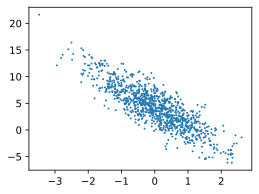

In [4]:
###通过生成第二个特征features[:, 1]和标签 labels 的散点图，可以更直观地观察两者间的线性关系。

def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(4, 3)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

##scatter绘制散点图
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);


In [5]:
# 本函数已保存在d2lzh包中方便以后使用

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = t.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)


batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X,"\n" ,y)
    break

tensor([[ 1.2086,  0.3067],
        [-0.6989, -0.0462],
        [ 2.5541,  1.4967],
        [ 1.0344, -0.2376],
        [ 0.1517,  0.4933],
        [-1.5241,  0.3150],
        [-0.3928, -0.6434],
        [ 0.0843, -0.1782],
        [-1.8161, -1.4635],
        [ 0.5466, -2.0042]]) 
 tensor([ 5.5860,  2.9603,  4.2152,  7.0705,  2.8368,  0.0832,  5.5943,  4.9846,
         5.5377, 12.1170])


In [8]:
##读取数据
#在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。
#这里我们定义一个函数：它每次返回batch_size（批量大小）个随机样本的特征和标签。
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = t.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)


In [9]:
#让我们读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量大小和输入个数；标签形状为批量大小。
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


tensor([[ 0.2619, -2.7665],
        [-0.1005, -0.9722],
        [-1.2286,  2.3176],
        [ 1.2849,  0.4245],
        [-3.3052,  0.3436],
        [-1.1416,  0.2001],
        [ 0.3985,  0.2973],
        [ 0.2764,  0.2257],
        [ 1.8966,  0.0679],
        [ 1.5842,  1.3554]]) tensor([14.1228,  7.3023, -6.1384,  5.3447, -3.5809,  1.2349,  3.9850,  3.9778,
         7.7558,  2.7562])


In [11]:
##初始化模型参数

#我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。
w = t.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=t.float32)
b = t.zeros(1, dtype=t.float32)

#之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们要让它们的requires_grad=True。
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

In [15]:
##定义模型

#下面是线性回归的矢量计算表达式的实现。我们使用mm函数做矩阵乘法。
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return t.mm(X, w) + b

##定义损失函数

#我们使用上一节描述的平方损失来定义线性回归的损失函数。
#在实现中，我们需要把真实值y变形成预测值y_hat的形状。以下函数返回的结果也将和y_hat的形状相同。
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2


In [16]:
##定义优化算法

#以下的sgd函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。
#这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

In [17]:
##训练模型

#在训练中，我们将多次迭代模型参数
#在每次迭代中，我们根据当前读取的小批量数据样本（特征X和标签y），
#通过调用反向函数backward计算小批量随机梯度，并调用优化算法sgd迭代模型参数。
#由于我们之前设批量大小batch_size为10，每个小批量的损失l的形状为(10, 1)。
#由于变量l并不是一个标量，所以我们可以调用.sum()将其求和得到一个标量，再运行l.backward()得到该变量有关模型参数的梯度。
#注意在每次更新完参数后不要忘了将参数的梯度清零。

#在一个迭代周期（epoch）中，我们将完整遍历一遍data_iter函数，
#并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
#这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设3和0.03

lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))


epoch 1, loss 0.039562
epoch 2, loss 0.000161
epoch 3, loss 0.000049


In [18]:
#训练完成后，我们可以比较学到的参数和用来生成训练集的真实参数。它们应该很接近。
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9997],
        [-3.3994]], requires_grad=True)
4.2 
 tensor([4.1993], requires_grad=True)
